In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score


In [34]:
df = pd.read_csv('StudentsPerformance.csv')

In [6]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [10]:
df.columns

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score'],
      dtype='object')

In [12]:
df.shape

(1000, 8)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [16]:
df.describe()

,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


In [18]:
df.isnull().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

In [36]:
df

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95
996,male,group C,high school,free/reduced,none,62,55,55
997,female,group C,high school,free/reduced,completed,59,71,65
998,female,group D,some college,standard,completed,68,78,77


In [24]:
# List of categorical columns in the dataset.
# These columns contain text values, so they need to be converted into numbers before training.
cat_cols = ["gender", "race/ethnicity", "parental level of education",
            "lunch", "test preparation course"]

In [38]:
# Splitting features (X) and target variable (y).
# X contains all columns except "math score".
# y contains the values we want to predict (math score).
X = df.drop("math score", axis=1)
y = df["math score"]

In [26]:
# Creating a ColumnTransformer for preprocessing.
# OneHotEncoder converts categorical text columns into numeric binary columns.
# handle_unknown='ignore' prevents errors if a new category appears in test data.
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ],
    remainder="passthrough"   # Keep the remaining numeric columns as they are.
)

In [56]:
# Building a pipeline that performs:
# 1) Preprocessing (encode categories)
# 2) Model training (Linear Regression)
# The Pipeline ensures the model always receives preprocessed numeric data.
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

In [40]:
# Splitting the dataset into training and testing sets.
# 80% training data, 20% testing data.
# random_state ensures reproducibility — same split every time.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.0005),
    "Random Forest": RandomForestRegressor(
        n_estimators=300, random_state=42
    ),
    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=300, learning_rate=0.05,
        max_depth=4, random_state=42
    )
}


In [42]:
print("===== MODEL PERFORMANCE (R² Score) =====")
for name, model in models.items():
    pipe = Pipeline([
        ("prep", preprocessor),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    print(f"{name}: R² = {r2_score(y_test, preds):.4f}")

===== MODEL PERFORMANCE (R² Score) =====
Linear Regression: R² = 0.8804
Ridge: R² = 0.8805
Lasso: R² = 0.8805
Random Forest: R² = 0.8519
Gradient Boosting: R² = 0.8712


In [44]:
print("===== OVERFITTING CHECK (Train vs Test R²) =====")
for name, model in models.items():
    pipe = Pipeline([
        ("prep", preprocessor),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)

    train_pred = pipe.predict(X_train)
    test_pred = pipe.predict(X_test)

    print(f"{name}: Train R² = {r2_score(y_train, train_pred):.4f} | Test R² = {r2_score(y_test, test_pred):.4f}")

===== OVERFITTING CHECK (Train vs Test R²) =====
Linear Regression: Train R² = 0.8743 | Test R² = 0.8804
Ridge: Train R² = 0.8743 | Test R² = 0.8805
Lasso: Train R² = 0.8743 | Test R² = 0.8805
Random Forest: Train R² = 0.9773 | Test R² = 0.8519
Gradient Boosting: Train R² = 0.9433 | Test R² = 0.8712


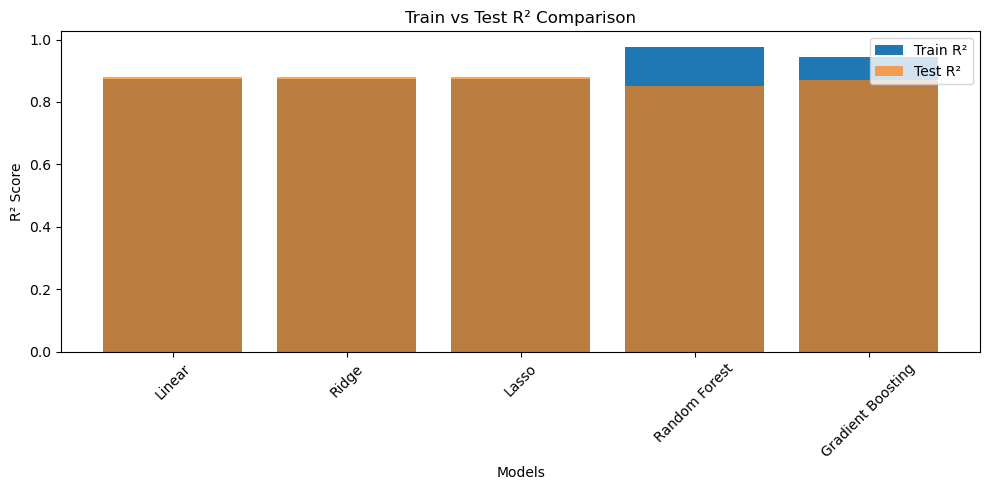

In [46]:
# Data provided
models = ["Linear", "Ridge", "Lasso", "Random Forest", "Gradient Boosting"]
train_r2 = [0.8743, 0.8743, 0.8743, 0.9773, 0.9433]
test_r2 = [0.8804, 0.8805, 0.8805, 0.8519, 0.8712]

# Plot
plt.figure(figsize=(10,5))
plt.bar(models, train_r2, label="Train R²")
plt.bar(models, test_r2, bottom=None, label="Test R²", alpha=0.7)
plt.xlabel("Models")
plt.ylabel("R² Score")
plt.title("Train vs Test R² Comparison")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
